<a href="https://colab.research.google.com/github/meryamhzamiensi/Quantum-Enhanced-Deep-Learning-for-Precision-Drug-Design-in-Breast-Cancer-Treatment/blob/ML-models/PCD_data_encoded4_classic_RandomForest100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Étape 1 : Importation des bibliothèques
!pip install pennylane
import pennylane as qml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time
import tracemalloc
import psutil
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 65.7 MB/s eta 0:00:00


In [ ]:
def track_memory_usage():
    """
    Track memory usage of the current process

    Returns:
    dict: Memory usage statistics
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()

    return {
        'rss_mb': memory_info.rss / (1024 * 1024),  # Resident Set Size in MB
        'vms_mb': memory_info.vms / (1024 * 1024),  # Virtual Memory Size in MB
    }

In [ ]:
def calculate_detailed_errors(y_test, y_pred):
    """
    Calculate detailed error metrics

    Parameters:
    y_test (array): True labels
    y_pred (array): Predicted labels

    Returns:
    dict: Error analysis metrics
    """
     # Convert encoded labels back to drug names
    y_test_names = y_test
    y_pred_names = y_pred

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_names, y_pred_names)

    # Detailed error analysis
    error_analysis = {
        'total_samples': len(y_test),
        'misclassified_samples': np.sum(y_test != y_pred),
        'misclassification_rate': 1 - accuracy_score(y_test, y_pred),
        'confusion_matrix': conf_matrix
    }

    # Per-drug error analysis
    drug_error_details = {}
    unique_drugs = np.unique(y_test_names)

    for drug in unique_drugs:
        drug_mask = (y_test_names == drug)
        drug_true = y_test_names[drug_mask]
        drug_pred = y_pred_names[drug_mask]

        drug_error_details[drug] = {
            'total_samples': len(drug_true),
            'correct_predictions': np.sum(drug_true == drug_pred),
            'incorrect_predictions': np.sum(drug_true != drug_pred),
            'accuracy': accuracy_score(drug_true, drug_pred)
        }

    error_analysis['per_drug_details'] = drug_error_details

    return error_analysis

In [ ]:
# Load the dataset
breast_cancer_data = pd.read_csv('processed_dataset.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
# 7. Prepare target variable (binned LN_IC50)
y = pd.cut(
        breast_cancer_data['LN_IC50'],
        bins=5,
        labels=['very_low', 'low', 'medium', 'high', 'excellent']
    )
print("\nTarget class distribution:")
print(y.value_counts())

    # Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# On supprime la colonne LN_IC50 de X
X = breast_cancer_data.drop(columns=['LN_IC50'])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print(f"\nFinal dataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")



Target class distribution:
LN_IC50
medium       6726
high         4457
low          1428
very_low      340
excellent     155
Name: count, dtype: int64

Final dataset shapes:
X_train: (10484, 503), y_train: (10484,)
X_test: (2622, 503), y_test: (2622,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# 1. First ensure proper data scaling
scaler = MinMaxScaler(feature_range=(0, np.pi))  # Quantum circuits need angles between 0 and pi
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Set up quantum device (using 10 qubits for this example)
n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

# Define quantum circuit directly
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Encode features into quantum states
    for i in range(n_qubits):
        qml.RY(np.pi * inputs[i % len(inputs)], wires=i)

    # Apply entangling layers
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])

    # Apply parameterized rotation gates
    for i in range(n_qubits):
        qml.RX(weights[i], wires=i)

    # Measure all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


In [ ]:
# Initialize quantum weights
quantum_weights = np.random.randn(n_qubits)

In [ ]:
def quantum_transform(X_data):
    # Ensure 2D array input
    if len(X_data.shape) == 1:
        X_data = X_data.reshape(1, -1)

    quantum_features = []
    for sample in X_data:
        # Convert sample to numpy array explicitly
        sample = np.array(sample, dtype=np.float32).flatten()
        quantum_features.append(quantum_circuit(sample, quantum_weights))

    return np.array(quantum_features)

# 4. Apply transformation
try:
    X_train_q = quantum_transform(X_train_scaled)
    X_test_q = quantum_transform(X_test_scaled)
except Exception as e:
    print(f"Error during quantum transformation: {e}")

In [ ]:
# Start memory tracking
tracemalloc.start()

In [ ]:
# Initial memory snapshot
initial_memory = track_memory_usage()
print("Initial Memory Usage:")
print(f"RSS: {initial_memory['rss_mb']:.2f} MB")
print(f"VMS: {initial_memory['vms_mb']:.2f} MB")

Initial Memory Usage:
RSS: 616.54 MB
VMS: 2162.43 MB


In [ ]:
start_time = time.time()

In [ ]:
# Étape 9 : Entraînement du modèle Random Forest (classification)
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
print("\nTraining Random Forest model...")
rf_model.fit(X_train_q, y_train)
print("Model training completed.")



Training Random Forest model...
Model training completed.


In [ ]:
# Étape 13 : Temps & mémoire
end_time = time.time()
execution_time = end_time - start_time
print(f"\nExecution time: {execution_time:.2f} seconds")

final_memory = track_memory_usage()
print("Final Memory Usage:")
print(f"RSS: {final_memory['rss_mb']:.2f} MB")
print(f"VMS: {final_memory['vms_mb']:.2f} MB")


Execution time: 5.58 seconds
Final Memory Usage:
RSS: 659.13 MB
VMS: 2242.43 MB


In [ ]:
# Get memory allocation details
current, peak = tracemalloc.get_traced_memory()
print(f"\nCurrent memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")
tracemalloc.stop()


Current memory usage: 0.29 MB
Peak memory usage: 2.25 MB


Accuracy: 0.8443935926773455

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        31
           1       0.83      0.86      0.84       892
           2       0.85      0.70      0.77       286
           3       0.85      0.87      0.86      1345
           4       0.91      0.78      0.84        68

    accuracy                           0.84      2622
   macro avg       0.89      0.82      0.85      2622
weighted avg       0.84      0.84      0.84      2622



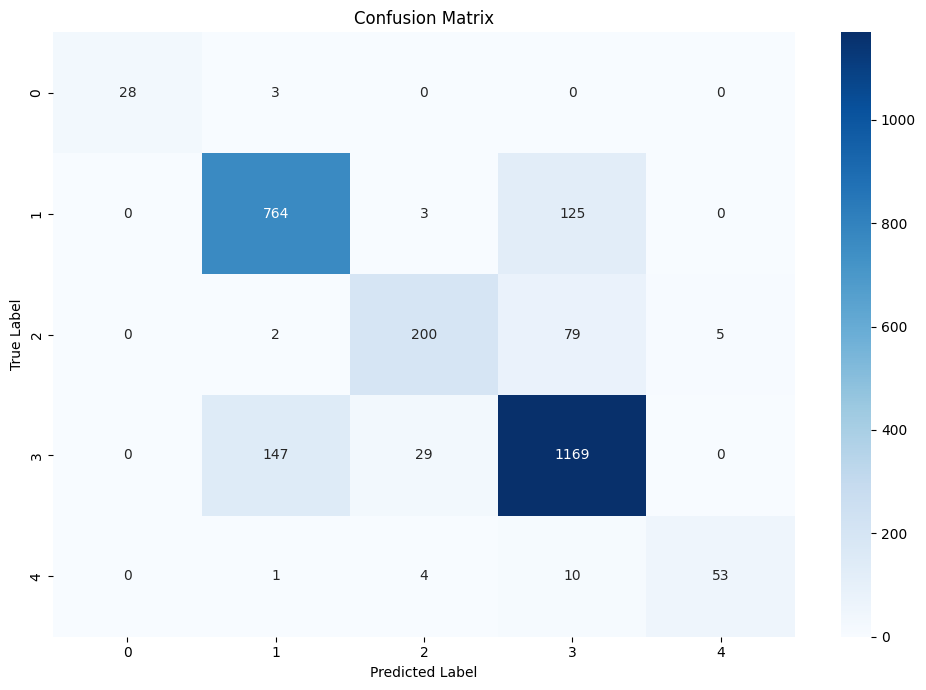

In [ ]:
#Étape 10 : Prédiction
y_pred = rf_model.predict(X_test_q)

# Étape 11 : Évaluation du modèle
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report


 # Evaluate the model directly using y_pred and y_test (no inverse_transform)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# Confusion Matrix Visualization
plt.figure(figsize=(10,7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
import pickle

# Remplace ‘model’ par rf_model (le nom de ta variable)
with open('q_data_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Modèle enregistré dans rf_100_model.pkl")


Modèle enregistré dans rf_100_model.pkl
